In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


In [2]:
base_path = "Semantic segmentation dataset/"
patch_size = 256
scaler = MinMaxScaler()

In [3]:
image_dataset = []  
for path, subdirs, files in os.walk(base_path):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                #print("Now patchifying IMAGE:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

In [4]:
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(base_path):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

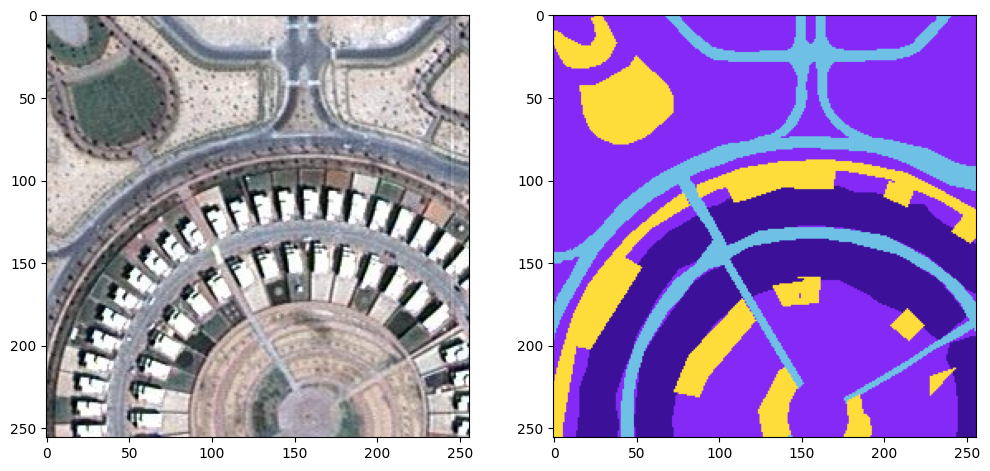

In [6]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [7]:
building = "3C1098"
building = np.array(tuple(int(building[i:i+2], 16) for i in (0,2,4)))
land = "8429F6"
land = np.array(tuple(int(land[i:i+2], 16) for i in (0,2,4)))
road = "6EC1E4"
road = np.array(tuple(int(road[i:i+2], 16) for i in (0,2,4)))
vegetation = "FEDD3A"
vegetation = np.array(tuple(int(vegetation[i:i+2], 16) for i in (0,2,4)))
water = "E2A929"
water = np.array(tuple(int(water[i:i+2], 16) for i in (0,2,4)))
unlabelled = "9B9B9B"
unlabelled = np.array(tuple(int(unlabelled[i:i+2], 16) for i in (0,2,4)))

label = single_patch_mask

In [8]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == building, axis = -1)] = 0
    label_seg[np.all(label == land, axis = -1)] = 1
    label_seg[np.all(label == road, axis = -1)] = 2
    label_seg[np.all(label == vegetation, axis = -1)] = 3
    label_seg[np.all(label == water, axis = -1)] = 4
    label_seg[np.all(label == unlabelled, axis = -1)] = 5
    
    label_seg = label_seg[:,:,0]
    return label_seg

In [9]:
labels = []

for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)
    
labels = np.array(labels)
labels = np.expand_dims(labels, axis = 3)

In [10]:
print(f"Unique labels: {np.unique(labels)}")

Unique labels: [0 1 2 3 4 5]


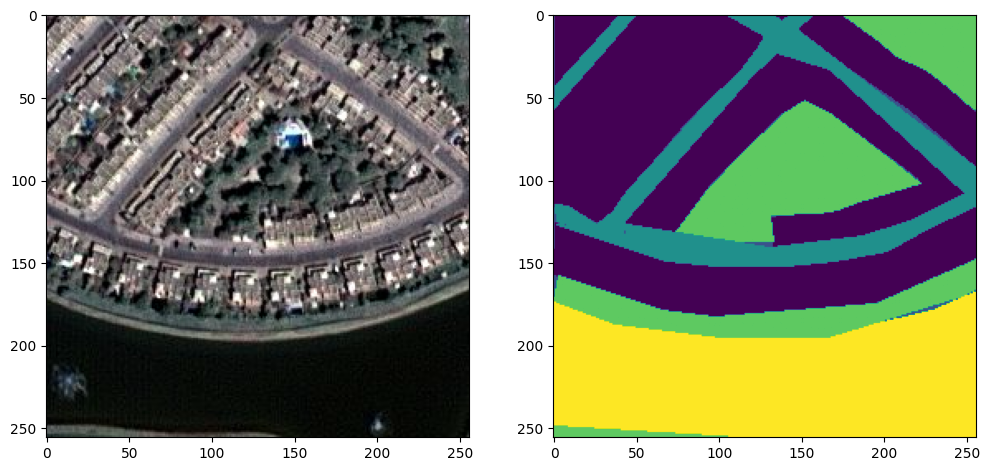

In [11]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [12]:
from tensorflow.keras.utils import to_categorical

n_classes = len(np.unique(labels))
labels_onehot = to_categorical(labels, num_classes=n_classes)

In [13]:
n_classes

6

In [14]:
weights = [1/n_classes for i in range(n_classes)]

In [15]:
weights

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666]

In [16]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_onehot,
                                                   test_size = 0.20)

In [18]:
img_height = X_train.shape[1]
img_width = X_train.shape[2]
img_channels = X_train.shape[3]

In [19]:
from basic_unet import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef, sm.metrics.IOUScore(threshold = 0.5)]

In [20]:
model = multi_unet_model(n_classes, img_height, img_width, img_channels)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [22]:
model.compile(optimizer="adam", loss = total_loss, metrics = metrics)

In [23]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
66/66 [==============================] - 12s 127ms/step - loss: 0.9918 - accuracy: 0.5707 - jacard_coef: 0.2991 - iou_score: 0.1531 - val_loss: 0.9967 - val_accuracy: 0.6432 - val_jacard_coef: 0.3951 - val_iou_score: 0.2163
Epoch 2/100
66/66 [==============================] - 7s 100ms/step - loss: 0.9639 - accuracy: 0.6896 - jacard_coef: 0.4323 - iou_score: 0.3101 - val_loss: 0.9738 - val_accuracy: 0.6760 - val_jacard_coef: 0.3320 - val_iou_score: 0.2618
Epoch 3/100
66/66 [==============================] - 7s 101ms/step - loss: 0.9536 - accuracy: 0.7318 - jacard_coef: 0.4751 - iou_score: 0.3705 - val_loss: 0.9567 - val_accuracy: 0.7174 - val_jacard_coef: 0.4343 - val_iou_score: 0.3596
Epoch 4/100
66/66 [==============================] - 7s 100ms/step - loss: 0.9487 - accuracy: 0.7419 - jacard_coef: 0.4987 - iou_score: 0.3944 - val_loss: 0.9532 - val_accuracy: 0.7145 - val_jacard_coef: 0.4448 - val_iou_score: 0.3816
Epoch 5/100
66/66 [==============================] - 7s 103

Epoch 36/100
66/66 [==============================] - 7s 99ms/step - loss: 0.9038 - accuracy: 0.8576 - jacard_coef: 0.7082 - iou_score: 0.5995 - val_loss: 0.9183 - val_accuracy: 0.8308 - val_jacard_coef: 0.6791 - val_iou_score: 0.5415
Epoch 37/100
66/66 [==============================] - 7s 99ms/step - loss: 0.9031 - accuracy: 0.8571 - jacard_coef: 0.7074 - iou_score: 0.6049 - val_loss: 0.9211 - val_accuracy: 0.8260 - val_jacard_coef: 0.6733 - val_iou_score: 0.5291
Epoch 38/100
66/66 [==============================] - 7s 99ms/step - loss: 0.9039 - accuracy: 0.8547 - jacard_coef: 0.7038 - iou_score: 0.6014 - val_loss: 0.9217 - val_accuracy: 0.8201 - val_jacard_coef: 0.6596 - val_iou_score: 0.5258
Epoch 39/100
66/66 [==============================] - 7s 99ms/step - loss: 0.9027 - accuracy: 0.8578 - jacard_coef: 0.7090 - iou_score: 0.6037 - val_loss: 0.9207 - val_accuracy: 0.8232 - val_jacard_coef: 0.6708 - val_iou_score: 0.5397
Epoch 40/100
66/66 [==============================] - 7s 99m

Epoch 71/100
66/66 [==============================] - 7s 99ms/step - loss: 0.8821 - accuracy: 0.8954 - jacard_coef: 0.7776 - iou_score: 0.7139 - val_loss: 0.9097 - val_accuracy: 0.8553 - val_jacard_coef: 0.7246 - val_iou_score: 0.5822
Epoch 72/100
66/66 [==============================] - 7s 99ms/step - loss: 0.8883 - accuracy: 0.8820 - jacard_coef: 0.7560 - iou_score: 0.6860 - val_loss: 0.9274 - val_accuracy: 0.8001 - val_jacard_coef: 0.6193 - val_iou_score: 0.4922
Epoch 73/100
66/66 [==============================] - 7s 99ms/step - loss: 0.8978 - accuracy: 0.8572 - jacard_coef: 0.7074 - iou_score: 0.6324 - val_loss: 0.9134 - val_accuracy: 0.8441 - val_jacard_coef: 0.6996 - val_iou_score: 0.5653
Epoch 74/100
66/66 [==============================] - 7s 99ms/step - loss: 0.8891 - accuracy: 0.8789 - jacard_coef: 0.7480 - iou_score: 0.6755 - val_loss: 0.9254 - val_accuracy: 0.8134 - val_jacard_coef: 0.6623 - val_iou_score: 0.5170
Epoch 75/100
66/66 [==============================] - 7s 99m

In [24]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5859569


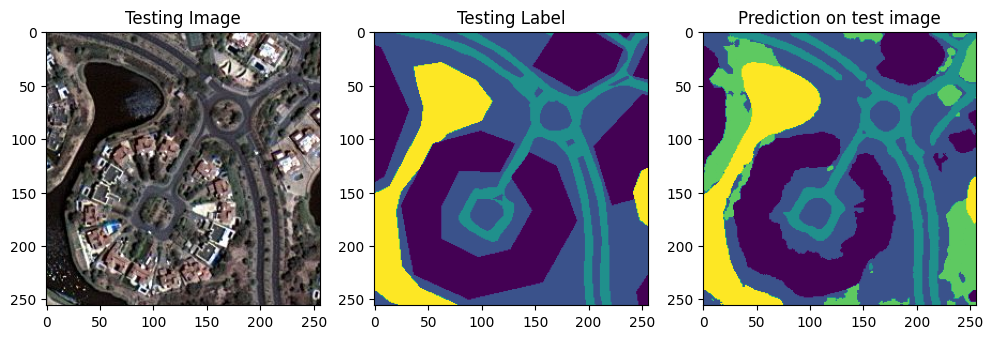

In [27]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()